In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,8]

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [3]:
dat = pd.read_csv('Data/aqi_sample_data_wakulla_florida_bdate_20170101_edate_20191231_wind_speed_dir.csv')
print(dat.shape)
dat.head(5)

(26280, 12)


,latitude,longitude,date_gmt,time_gmt,datetime_gmt,state,county,Wind_Speed,Wind_Direction,Barometric_Pressure,cos_Wind_Dir,sin_Wind_Dir
0,30.0925,-84.161111,1/1/2017,5:00,1/1/2017 5:00,Florida,Wakulla,6.7,83.0,1017.0,0.121869,0.992546
1,30.0925,-84.161111,1/1/2017,6:00,1/1/2017 6:00,Florida,Wakulla,5.2,88.0,1017.0,0.034899,0.999391
2,30.0925,-84.161111,1/1/2017,7:00,1/1/2017 7:00,Florida,Wakulla,5.0,94.0,1017.0,-0.069756,0.997564
3,30.0925,-84.161111,1/1/2017,8:00,1/1/2017 8:00,Florida,Wakulla,5.6,104.0,1016.0,-0.241922,0.970296
4,30.0925,-84.161111,1/1/2017,9:00,1/1/2017 9:00,Florida,Wakulla,7.0,129.0,1016.0,-0.629320,0.777146


<AxesSubplot:>

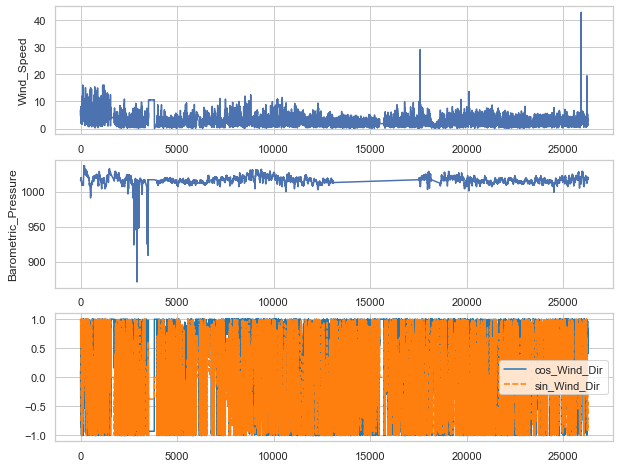

In [4]:
#pre-progressing

sns.set_theme(style = "whitegrid")

fig, axs = plt.subplots(nrows = 3)
sns.lineplot(data = dat["Wind_Speed"], palette = "tab10", ax = axs[0])
sns.lineplot(data = dat[ "Barometric_Pressure"], palette = "tab10", ax = axs[1])
sns.lineplot(data = dat[["cos_Wind_Dir", "sin_Wind_Dir"]], palette = "tab10", ax = axs[2])

In [5]:
#fill-forward miss-data
from pandas._config import dates

dat_prep = dat.copy()
dat_prep["datetime_gmt"] = pd.to_datetime(dat_prep["datetime_gmt"])
# dat_prep.rename(columns = {"datetime_gmt": "datetime"}, inplace = True)
# dat = dat.loc[~dat.Barometric_Pressure.isna(),:]
dat_prep = dat_prep.set_index("datetime_gmt")
dat_prep = dat.drop(['latitude', 'longitude', 'date_gmt', 'time_gmt', 'state', 'county', 'Wind_Direction'], axis = 1)

dat_prep.fillna(method = "pad", inplace = True)
dat_prep = dat_prep.dropna()
print(dat_prep.shape)
dat_prep.head(5)

(26280, 5)


,datetime_gmt,Wind_Speed,Barometric_Pressure,cos_Wind_Dir,sin_Wind_Dir
0,1/1/2017 5:00,6.7,1017.0,0.121869,0.992546
1,1/1/2017 6:00,5.2,1017.0,0.034899,0.999391
2,1/1/2017 7:00,5.0,1017.0,-0.069756,0.997564
3,1/1/2017 8:00,5.6,1016.0,-0.241922,0.970296
4,1/1/2017 9:00,7.0,1016.0,-0.629320,0.777146


In [6]:
dat_prep = dat_prep.set_index("datetime_gmt")
dat_prep

,Wind_Speed,Barometric_Pressure,cos_Wind_Dir,sin_Wind_Dir
datetime_gmt,,,,
1/1/2017 5:00,6.7,1017.0,0.121869,0.992546
1/1/2017 6:00,5.2,1017.0,0.034899,0.999391
1/1/2017 7:00,5.0,1017.0,-0.069756,0.997564
1/1/2017 8:00,5.6,1016.0,-0.241922,0.970296
1/1/2017 9:00,7.0,1016.0,-0.629320,0.777146
...,...,...,...,...
1/1/2020 0:00,1.6,1019.0,0.453991,-0.891007
1/1/2020 1:00,1.6,1019.0,0.500000,-0.866025
1/1/2020 2:00,2.1,1019.0,0.601815,-0.798636


In [7]:
# split data
n_train = int(len(dat_prep) * 0.7)

train_dat = dat_prep.iloc[:n_train]
test_dat = dat_prep.iloc[n_train:]

In [8]:
# pre-processing
scaler_speed = MinMaxScaler().fit(train_dat[['Wind_Speed']])
scaler_press = MinMaxScaler().fit(train_dat[['Barometric_Pressure']])

train_dat[['Wind_Speed']] = scaler_speed.transform(train_dat[['Wind_Speed']])
test_dat[['Wind_Speed']] = scaler_speed.transform(test_dat[['Wind_Speed']])

train_dat[['Barometric_Pressure']] = scaler_press.transform(train_dat[['Barometric_Pressure']])
test_dat[['Barometric_Pressure']] = scaler_press.transform(test_dat[['Barometric_Pressure']])

train_dat.head(5)

,Wind_Speed,Barometric_Pressure,cos_Wind_Dir,sin_Wind_Dir
datetime_gmt,,,,
1/1/2017 5:00,0.229452,0.879518,0.121869,0.992546
1/1/2017 6:00,0.178082,0.879518,0.034899,0.999391
1/1/2017 7:00,0.171233,0.879518,-0.069756,0.997564
1/1/2017 8:00,0.191781,0.873494,-0.241922,0.970296
1/1/2017 9:00,0.239726,0.873494,-0.629320,0.777146


In [9]:
# create dataset
def create_dataset(dat, lags = 1):
  """ GRU takes a 3D array so the data must be re-shaped to:
  - [N, T, P]
  - N = number of samples
  - T = number of time steps
  - P = number of predictors
  """
  Inputs, Outputs = [], []
  X = dat.to_numpy()

  for i in range(len(X) - lags):
    v = X[i:i+lags]
    Inputs.append(v)
    Outputs.append(X[i + lags])

  return np.array(Inputs), np.array(Outputs)

lags = 48

X_train, y_train = create_dataset(train_dat, lags)
X_test, y_test = create_dataset(test_dat, lags)

y_train = y_train[:, 0:1]
y_test = y_test[:, 0:1]

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (18348, 48, 4)
y_train.shape:  (18348, 1)
X_test.shape:  (7836, 48, 4)
y_test.shape:  (7836, 1)


In [10]:
# make and plot test forecasts with the Gaussian GRU model.
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')    
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Wind Speed')

def make_predictions(X_test, y_test, model, model_name):
    prediction = model.predict(X_test)
    pred = np.append(prediction, prediction, 1)
    pred = scaler_speed.inverse_transform(pred)
    pred_gru = pred[:,0]

    y_test_speed = scaler_speed.inverse_transform(y_test)
    plot_future(pred_gru, model_name, y_test_speed)

    return prediction, pred_gru

In [11]:
# normal GRU model with mse loss function
def create_GRU(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True, 
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 16))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1, activation = "relu"))

  # Compile Model
  model.compile(optimizer = 'adam', loss = 'mse') # loss function will be changed 

  return model
# normal GRU model with mse loss function
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15)
    history = model.fit(X_train, y_train, epochs = 70,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [12]:
# Gaussian
def Gaussian_GEVL_fn():
  def gevl_Gaussian(y_true, y_pred):
    delta = y_pred - y_true
    gevl = tf.exp(tf.square(-delta,2))
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Gaussian

# Gumbel GEVL
def gumbel_GEVL_fn(gamma):
  def gevl_gumbel(y_true, y_pred):
    delta = y_pred - y_true
    gevl = tf.multiply(tf.pow(1 - tf.exp(-tf.square(delta)), gamma), tf.square(delta))
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_gumbel

# Frechet GEVL
def Frechet_GEVL_fn(alpha,s):
  def gevl_Frechet(y_true, y_pred):
    delta = y_pred - y_true
    Zeta = tf.divide(delta,s) + tf.pow( (tf.divide(alpha,(1.0 + alpha))) ,tf.divide(1.0, alpha))
    
    gevl1 = tf.multiply(alpha + 1.0, tf.math.log(Zeta))
    gevl2 = tf.pow(Zeta, -alpha)
    gevl = tf.add(gevl1, gevl2)
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Frechet

# Cauchy
def Cauchy_GEVL_fn(tau):
  def gevl_Cauchy(y_true, y_pred):
    delta = y_pred - y_true
    gevl = tf.math.log(1.0 + tf.pow(delta / tau, 2.0))
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Cauchy

# Pareto
def Pareto_GEVL_fn(alpha,s):
  def gevl_Pareto(y_true, y_pred):
    delta = y_pred - y_true
    gevl = tf.multiply(tf.add(1.0,alpha),tf.math.log(delta))
    return tf.reduce_mean(gevl, axis = -1)
  return gevl_Pareto

Epoch 1/70
918/918 [==============================] - 17s 16ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 2/70
918/918 [==============================] - 17s 18ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 3/70
918/918 [==============================] - 16s 17ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 4/70
918/918 [==============================] - 16s 17ms/step - loss: 0.0019 - val_loss: 9.8583e-04
Epoch 5/70
918/918 [==============================] - 15s 17ms/step - loss: 0.0017 - val_loss: 9.1350e-04
Epoch 6/70
918/918 [==============================] - 15s 17ms/step - loss: 0.0017 - val_loss: 8.8217e-04
Epoch 7/70
918/918 [==============================] - 15s 17ms/step - loss: 0.0017 - val_loss: 8.9121e-04
Epoch 8/70
918/918 [==============================] - 15s 16ms/step - loss: 0.0016 - val_loss: 9.1578e-04
Epoch 9/70
918/918 [==============================] - 15s 16ms/step - loss: 0.0016 - val_loss: 9.0826e-04
Epoch 10/70
918/918 [==============================] - 15s

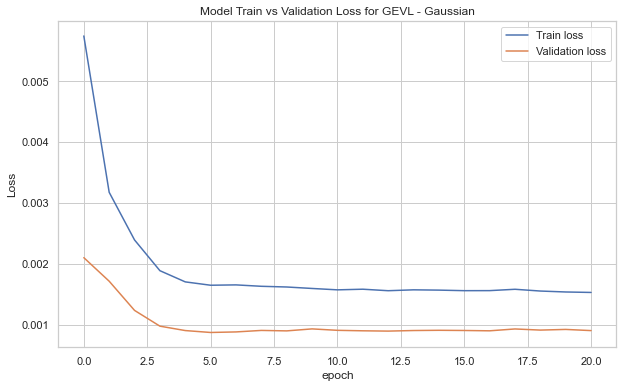

In [13]:
model_GRU = create_GRU(32)
history_gru = fit_model(model_GRU)

plot_loss (history_gru, 'GEVL - Gaussian')

Epoch 1/70
918/918 [==============================] - 21s 19ms/step - loss: 1.3358e-04 - val_loss: 1.8960e-04
Epoch 2/70
918/918 [==============================] - 17s 19ms/step - loss: 5.6406e-05 - val_loss: 1.6514e-04
Epoch 3/70
918/918 [==============================] - 17s 18ms/step - loss: 4.0799e-05 - val_loss: 1.3540e-04
Epoch 4/70
918/918 [==============================] - 18s 20ms/step - loss: 3.1192e-05 - val_loss: 1.1339e-04
Epoch 5/70
918/918 [==============================] - 19s 21ms/step - loss: 2.4595e-05 - val_loss: 9.4702e-05
Epoch 6/70
918/918 [==============================] - 20s 22ms/step - loss: 2.1030e-05 - val_loss: 8.1762e-05
Epoch 7/70
918/918 [==============================] - 19s 21ms/step - loss: 2.0469e-05 - val_loss: 7.3248e-05
Epoch 8/70
918/918 [==============================] - 19s 21ms/step - loss: 1.7630e-05 - val_loss: 6.3032e-05
Epoch 9/70
918/918 [==============================] - 19s 21ms/step - loss: 1.6396e-05 - val_loss: 5.9444e-05
Epoch 10/7

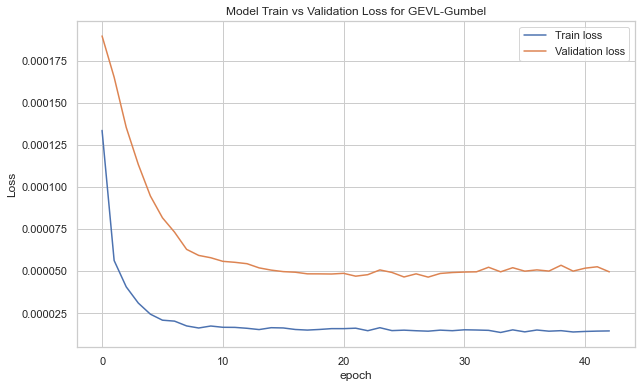

In [23]:
def create_GRU_Gumbel_GEVL(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True,
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 16))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))

  # Compile Model
  model.compile(optimizer = 'adam', loss = gumbel_GEVL_fn(gamma = 1.1))

  return model

model_GRU_gumbel = create_GRU_Gumbel_GEVL(32)
history_gumbel = fit_model(model_GRU_gumbel)

plot_loss(history_gumbel, 'GEVL-Gumbel')

Epoch 1/70
918/918 [==============================] - 20s 19ms/step - loss: 2.5254 - val_loss: 3.2100
Epoch 2/70
918/918 [==============================] - 17s 19ms/step - loss: 1.4235 - val_loss: 4.0468
Epoch 3/70
918/918 [==============================] - 16s 18ms/step - loss: 1.2907 - val_loss: 4.6121
Epoch 4/70
918/918 [==============================] - 17s 18ms/step - loss: 1.2134 - val_loss: 4.4725
Epoch 5/70
918/918 [==============================] - 17s 19ms/step - loss: 1.1751 - val_loss: 4.4490
Epoch 6/70
918/918 [==============================] - 17s 19ms/step - loss: 1.1376 - val_loss: 3.5996
Epoch 7/70
918/918 [==============================] - 15s 16ms/step - loss: 1.1176 - val_loss: 2.6625
Epoch 8/70
918/918 [==============================] - 15s 16ms/step - loss: 1.1021 - val_loss: 2.0277
Epoch 9/70
918/918 [==============================] - 15s 16ms/step - loss: 1.0877 - val_loss: 1.5782
Epoch 10/70
918/918 [==============================] - 17s 18ms/step - loss: 1.081

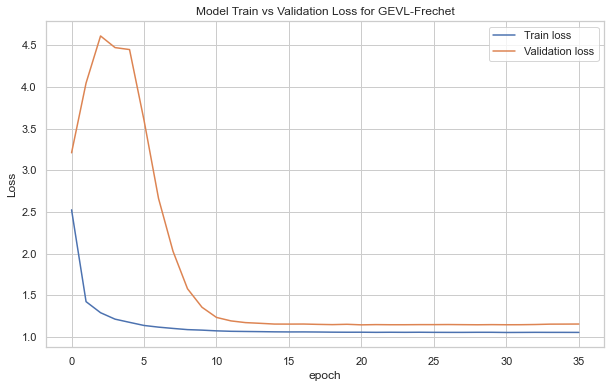

In [24]:
def create_GRU_Frechet_GEVL(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True,
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 16))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))

  # Compile Model
  model.compile(optimizer = 'adam', loss = Frechet_GEVL_fn(alpha = 13.0, s = 1.7))

  return model

model_GRU_frechet = create_GRU_Frechet_GEVL(32)
history_frechet = fit_model(model_GRU_frechet)

plot_loss(history_frechet, 'GEVL-Frechet')

Epoch 1/70
918/918 [==============================] - 17s 16ms/step - loss: 4.5592e-05 - val_loss: 1.7732e-05
Epoch 2/70
918/918 [==============================] - 15s 17ms/step - loss: 2.7196e-05 - val_loss: 1.3658e-05
Epoch 3/70
918/918 [==============================] - 15s 17ms/step - loss: 2.0709e-05 - val_loss: 1.0658e-05
Epoch 4/70
918/918 [==============================] - 15s 17ms/step - loss: 1.8455e-05 - val_loss: 9.6419e-06
Epoch 5/70
918/918 [==============================] - 15s 17ms/step - loss: 1.7469e-05 - val_loss: 9.5297e-06
Epoch 6/70
918/918 [==============================] - 15s 17ms/step - loss: 1.7119e-05 - val_loss: 9.5813e-06
Epoch 7/70
918/918 [==============================] - 15s 16ms/step - loss: 1.6695e-05 - val_loss: 9.3507e-06
Epoch 8/70
918/918 [==============================] - 15s 16ms/step - loss: 1.6493e-05 - val_loss: 9.3548e-06
Epoch 9/70
918/918 [==============================] - 15s 16ms/step - loss: 1.6250e-05 - val_loss: 9.3183e-06
Epoch 10/7

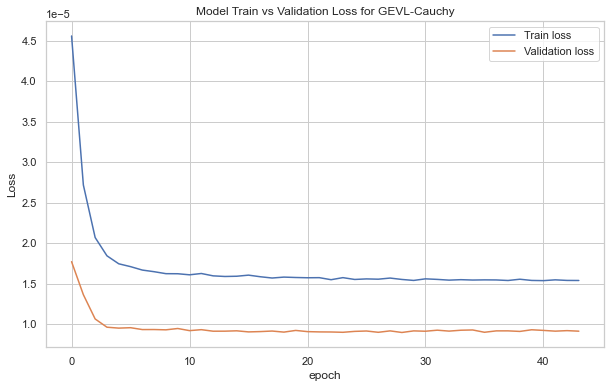

In [15]:
def create_GRU_Cauchy_GEVL(units):
  model = Sequential()

  # Input Layer
  model.add(GRU(units = units, return_sequences=True,
            input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  # Hidden Layer
  model.add(GRU(units = 16))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))

  # Compile Model
  model.compile(optimizer = 'adam', loss = Cauchy_GEVL_fn(tau = 10.0))

  return model

model_GRU_Cauchy = create_GRU_Cauchy_GEVL(32)
history_Cauchy = fit_model(model_GRU_Cauchy)

plot_loss(history_Cauchy, 'GEVL-Cauchy')

In [25]:
# def create_GRU_Pareto_GEVL(units):
#   model = Sequential()

#   # Input Layer
#   model.add(GRU(units = units, return_sequences=True,
#             input_shape = (X_train.shape[1], X_train.shape[2])))
#   model.add(Dropout(0.2))

#   # Hidden Layer
#   model.add(GRU(units = 16))
#   model.add(Dropout(0.2))
#   model.add(Dense(units = 1))

#   # Compile Model
#   model.compile(optimizer = 'adam', loss = Pareto_GEVL_fn(alpha = 13,s = 0.0))

#   return model

# model_GRU_Pareto = create_GRU_Pareto_GEVL(32)
# history_Pareto = fit_model(model_GRU_Pareto)

# plot_loss(history_Cauchy, 'GEVL-Pareto')

245/245 [==============================] - 1s 4ms/step


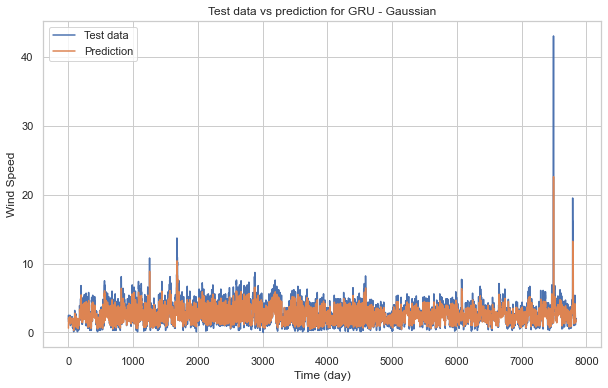

In [26]:
prediction_gru, pred_gru = make_predictions(X_test, y_test, model_GRU, "GRU - Gaussian")

245/245 [==============================] - 1s 4ms/step


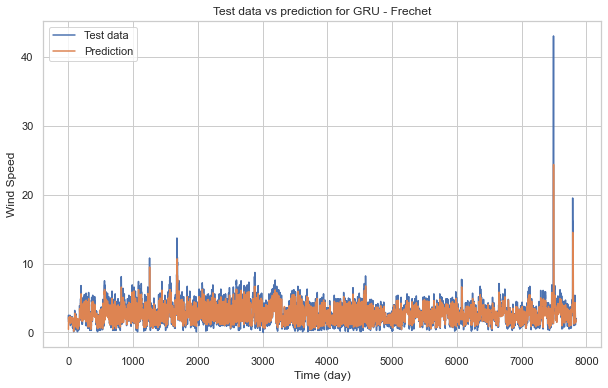

In [27]:
prediction_frechet, pred_frechet = make_predictions(X_test, y_test, model_GRU_frechet, 
                                                    "GRU - Frechet")

245/245 [==============================] - 1s 4ms/step


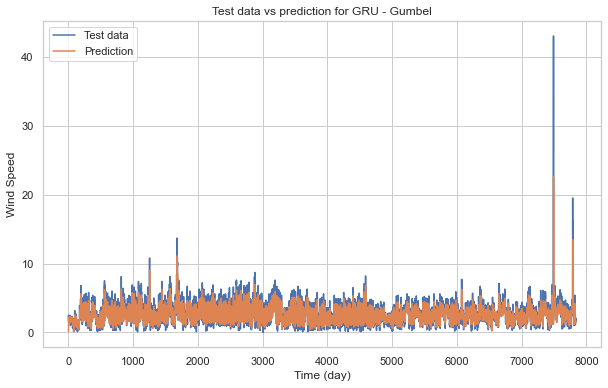

In [28]:
prediction_gumbel, pred_gumbel = make_predictions(X_test, y_test, model_GRU_gumbel, 
                                                    "GRU - Gumbel")

245/245 [==============================] - 1s 4ms/step


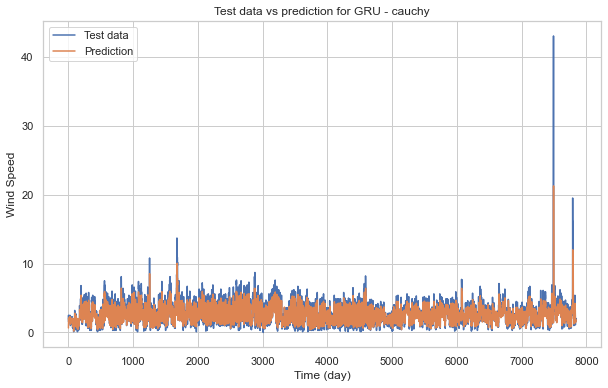

In [29]:
prediction_Cauchy, pred_Cauchy = make_predictions(X_test, y_test, model_GRU_Cauchy, 
                                                    "GRU - cauchy")

In [30]:
# prediction_Pareto, pred_Pareto = make_predictions(X_test, y_test, model_GRU_Pareto, 
#                                                     "GRU - Pareto")

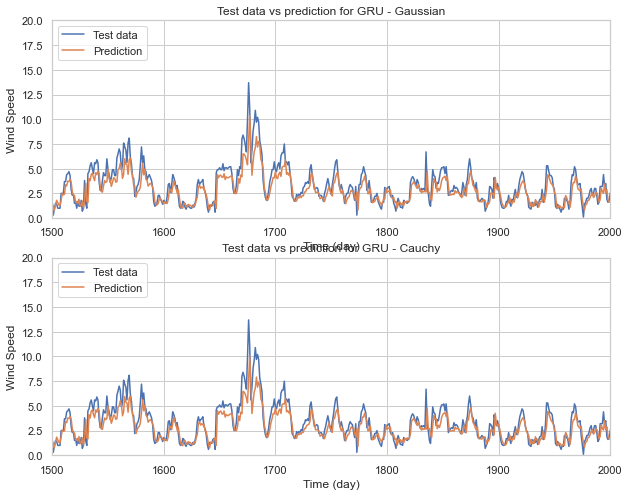

In [31]:
def plot_future2(ax, prediction, model_name, y_test, ylab):
    range_future = len(prediction)
    ax.plot(np.arange(range_future), np.array(y_test), 
             label='Test data')
    ax.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')    
    ax.set_title('Test data vs prediction for ' + model_name)
    ax.legend(loc='upper left')
    ax.set_xlabel('Time (day)')
    ax.set_ylabel(ylab)
    ax.set_xlim(1500, 2000)
    ax.set_ylim(0, 20)

y_test_speed = scaler_speed.inverse_transform(y_test)
fig, axs = plt.subplots(2)
plot_future2(axs[0], pred_gru, "GRU - Gaussian", y_test_speed, "Wind Speed")
plot_future2(axs[1], pred_Cauchy, "GRU - Cauchy", y_test_speed, "Wind Speed")

In [32]:
# compare the test forecasts using RMSE and MAE.

y_test_speed = scaler_speed.inverse_transform(y_test)
evaluate_prediction(prediction_gru, y_test_speed, 'GRU - Gaussian')
print("################")
evaluate_prediction(prediction_gumbel, y_test_speed, 'GRU - Gumbel')
print("################")
evaluate_prediction(prediction_frechet, y_test_speed, 'GRU - Frechet')
print("################")
evaluate_prediction(prediction_Cauchy, y_test_speed, 'GRU - Cauchy')


GRU - Gaussian:
Mean Absolute Error: 2.6766
Root Mean Square Error: 3.1250

################
GRU - Gumbel:
Mean Absolute Error: 2.6752
Root Mean Square Error: 3.1242

################
GRU - Frechet:
Mean Absolute Error: 2.6730
Root Mean Square Error: 3.1210

################
GRU - Cauchy:
Mean Absolute Error: 2.6758
Root Mean Square Error: 3.1244



Text(0, 0.5, 'GRU - Frechet')

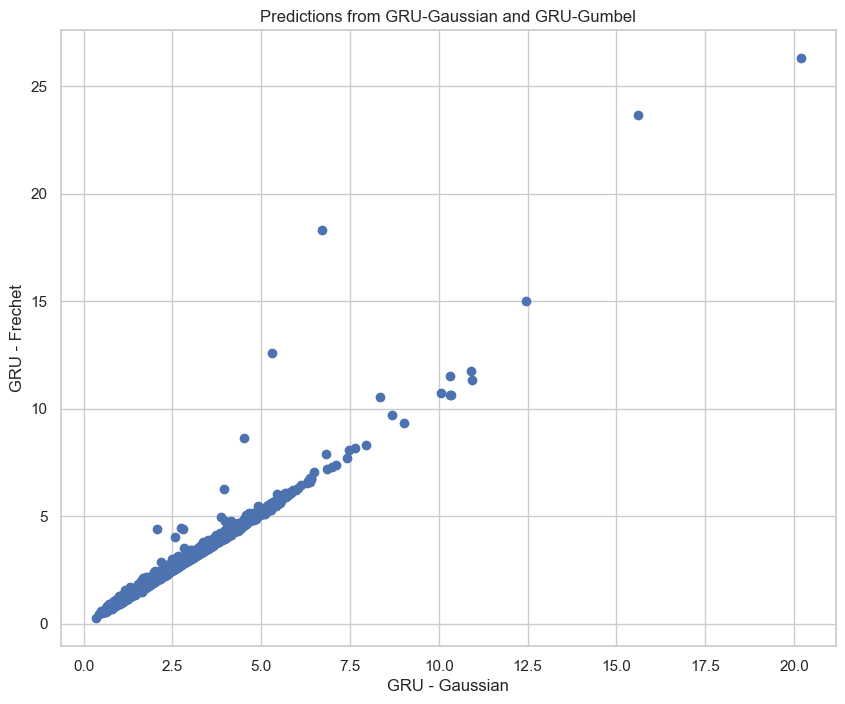

In [24]:
# plot comparing the test forecasts from each model.
fig, ax = plt.subplots()
ax.scatter(x = pred_gru, y = pred_frechet)
ax.set_title("Predictions from GRU-Gaussian and GRU-Gumbel")
ax.set_xlabel("GRU - Gaussian")
ax.set_ylabel("GRU - Frechet")

Text(0, 0.5, 'Residual - Frechet')

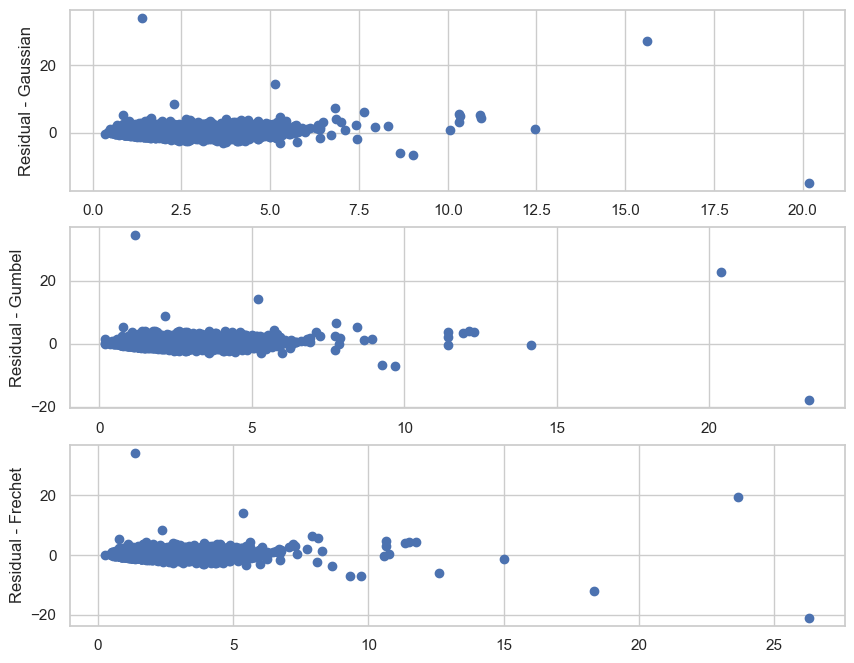

In [59]:
fig, axs = plt.subplots(3)
axs[0].scatter(y = np.subtract(y_test_speed[:,0], pred_gru), x = pred_gru)
axs[1].scatter(y = np.subtract(y_test_speed[:,0], pred_gumbel), x = pred_gumbel)
axs[2].scatter(y = np.subtract(y_test_speed[:,0], pred_frechet), x = pred_frechet)
axs[0].set_ylabel("Residual - Gaussian")
axs[1].set_ylabel("Residual - Gumbel")
axs[2].set_ylabel("Residual - Frechet")